# Overview


This notebook documents the analysis of a variety of reinforcement learning models dedicated to trading of SPDR S&P 500 ETF Trust (SPY) stock.  These models all use the same algorithms and structure, a Double Deep Q Learning model, but differ in their state space, or environment.

The goal of this project is to analyze how increasing the
complexity of a model's state space affects the model's performance. This is an interesting topic because naturally state spaces may be too simple to properly learn, but due to the "Curse of Dimensionality," if a state space gets too complicated, we can expect the model to overfit and possibly suffer worse performance.

This notebook stores each of the state spaces we experimented with, and allows a user to select a state space to train themselves due to the long processing time required to train each state space at once.


# Introduction


Advances in machine learning (ML) and artificial intelligence (AI) have enabled us to enhance our lives and tackle a variety of
complex problems. The financial market is a prime example of a field where researchers are employing these techniques. Since the financial market is very dynamic and ever fluctuating, it presents a unique challenges to consider when developing these systems, but also allows the power of machine learning and AI to shine. Before the development of AI, it was the job of investors and traders to use market data to make optimal decisions that maximize and reduce risk within the context of a trading system. However, due to market complexities, it can be challenging for agents to consider all the relevant information to take an informed position. This is where reinforcement learning (RL), an area of ML, comes into play. Through repeated interaction with a market environment, an RL agent can learn optimal trading strategies by taking certain actions, receiving rewards based on these, and adapting future actions based on previous experience.

Reinforcement Learning has a rich history of use in the realm of finance. In the 1990s, Moody and Saffell experimented with real-time recurrent learning in order to demonstrate a predictable structure to U.S. stock prices (Moody & Saffell, 1998). They claimed that their agent was able to make a 4000% profit over the simulated period of 1970 to 1994, far outperforming the S&P 500 stock index during the same timespan.

However, previous studies into applying reinforcement learning into finance have provided insufficient analysis of their chosen model compared to similar ones. For instance, Wu et al. came up with their own technical indicators to add to their reinforcement model [233]. However, they did not test their model against simpler models, they only tested it against the turtle trading strategy [256], a simple rule-based strategy. This is an issue due to the well-studied phenomenon known as the “curse of
dimensionality.” Simply put, as one adds more dimensions to a dataset with a fixed number of data points, the density of the data points gets smaller and thus it becomes harder to prevent models from overfitting. Somewhat paradoxically, this could lead to more complex models performing worse than simpler ones. Thus, it is important to test the model on multiple dimensionalities of data, to make sure the data is not too complex that it overfits,
or too simple that it can’t learn enough.

Since these papers do not provide an in-depth analysis, this notebook analyses how altering the complexity of data available to a trading agent affects its overall performance relative to the market. To do this, this notebook adopts a DDQN algorithm to trade in three environments, each focusing on one of equity indices, foreign exchange (Forex), and market3. Each market environment contains multiple state spaces with varying amounts of data and asset dimensionality, such as 1-Day returns, 5-Day returns, currencies and market3example. The user can then decide which dataset and state space to train, thus seeing how well each model performs, and which amount of dimentionality is the best.


# Data Description

We use three data sets for our models: one for equity indexes; one for the foreign exchange market;
and one for equity indexes intraday trading, specifically 5 minute intervals. These data sets were collected from
Refinitiv and Yahoo Finance, and they consist of the daily closing prices of
their respective assets, except for FX data which instead uses the open price.

This notebook uses the forex data.
For the forex data, we have the prices of GBPUSD(the exchange we are predicting), as well as the exchange rates EURUSD,
USDCHF, USDJPY, NZDCAD. We are using EURUSD and USDCHF as similar indices as they are geographicaly close to the UK.
This data is used in 5th and 6th models. We are then using USDJPY and NZDCAD as they are further removed from the UK and
actually make the model preform worse, thus showing the curse of dimensionality. That data is only used in our most
complex environment, the 6th model.

## <mark>For Documentation on Preparing the Program Environment see README.md </mark>


### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

# Methodology

Since we are comparing the effectiveness of data with different dimensionalities we naturally have to train multiple models. The state variables for each model is shown in the table below.

| Model 1 | Model 2 | Model 3 | Model 4 | Model 5 | Model 6 |
|-|-|-|-|-|-|
| 1-Day Return| Model 1 Vars.<br><br>Previous Action | Model 2 Vars.<br><br>Previous Price | Model 3 Vars.<br><br>2-Day Return<br><br>5-Day Return<br><br>10-Day Return<br><br>21-Day Return | Model 4 Vars.<br><br>2 Similar Exchanges'<br>· 1-Day Return<br>· 5-Day Return<br>· 21-Day Return | Model 5 Vars.<br><br>2 Unconnected Exchanges'<br>· 1-Day Return<br>· 5-Day Return<br>· 21-Day Return |

This notebook allows you to specify which state space you want to use, as training all of them at once could be very time-consuming.

### Settings
<mark> Select which model you want to run by setting the model variable


In [2]:
# model variables
#Which model to run(1 - 6, 0 being the simplest, 6 being the most complex)
model = 1
trading_cost_bps = .001 #trading cost percent, i.e. .01 is a 1% trading cost
time_cost_bps = .0001 #time cost, deducted every day the agent doesn't do something differents
batch_size = 256 # for training set to 4096, the batch size to train the NNs on
max_episodes = 20
epsilon_decay_steps = max_episodes/2 # for training set to 250, how many steps it takes epsilon to go from 1 to .01

#Random setup stuff
np.random.seed(42)
tf.random.set_seed(42)
sns.set_style('whitegrid')

#Use a GPU is we have one
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

#Set up results directory
results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)


### Helper functions
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

Using CPU


## Simulation Environment

Our environment is a fairly simple market trading simulation. The agent has a choice of three actions:

>A = E{0,1,2}, Sell Short, Flat, Buy Long

Where
* 0: Agent shorts the index fund equal to the amount of possessed capital.
* 1: Agent transfers all possessed capital into cash and closes all short positions
* 2: Agent buys as much of the given fund as possible with the possessed capital.

This is a very simplistic model because the agent cannot invest only a portion of it's capital; it must invest all of its capital or none.

At each time step, the simulation updates the portfolio's Net Asset Value (NAV), and performs the agent's chosen action. The NAV is calculated by the following formula:

$$
NAV_{new} = NAV_{old} * (1 + Reward)
$$

The function rewarding the agent is simply the percentage change of the NAV. The simulation uses the following equation
to calculate the reward function:

$$
Reward = [(a_{n} - 1) * Return_{n+1}] – trading\_cost\_bps*|(a_{n} - 1) - (a_{n-1} - 1)| – dailyCost
$$
<br>
where
$$
a_{n} = max(neuralNetwork.predict(S_{n})) ∈ {0, 1, 2}
$$

$$
dailyCost =
  \begin{cases}
    0 &\text{if } a_{n} = a_{n-1}\\\
    \text{time_cost_bps} &\text{else }
  \end{cases}
$$

Where a<sub>n</sub> is the nth action, S<sub>n</sub> is the nth state, and Return<sub>n</sub> is the 1 day return of the market as found in S<sub>n</sub>.
Actions are decremented by 1 so that it translates the action space to -1, 0, and 1. This way, if the agent held cash (now equal to 0), the 1-Day Return will not affect the NAV. If agent bought the stock (now equal
to 1), the percent change of NAV will directly correlate to the 1-Day Return. And if the agent instead shorted, the percent change would be inversely correlated to the 1-Day Return.
The number of trades are calculated by the equation |(a<sub>n</sub> - 1) - (a<sub>n-1</sub> - 1)|, because if both actions are the same,
 the agent doesn’t need to trade anything to execute the action. If the agent wants to buy and it previously
 only held cash, it would only have to buy |0 - 1| = 1 unit of the stock. Whereas if the agent wants to then
 short, it would first have to sell all the stock it already has and then short that amount again, resulting
 in |1 - (-1)| = 2 units of trading it would have to do. The amount needed to trade is then multiplied by the
 trading costs. The daily cost is used to disincentivize the agent from being too passive. If the agent
 repeats an action, the daily cost is set to the specified value, in our case 0.0001, but if the agent performs
 a different action, and thus trades something, the dailyCost will be set to 0.


## Set up Gym Environment

In [3]:
#Simulation variables
trading_days = 252 #days per episode
#trading_cost_bps = 0
#time_cost_bps = 0

#create the gym environment using the trading_env.py file
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days

)

#print environment variables
f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.2%}'

'Trading costs: 0.10% | Time costs: 0.01%'

In [4]:
#Initalize environment
trading_environment = gym.make('trading-v0', trading_days = trading_days, model = model)
trading_environment.env.trading_days = trading_days
trading_environment.env.data_source.trading_days = trading_days
trading_environment.env.simulator.steps = trading_days

trading_environment.env.trading_cost_bps = trading_cost_bps
trading_environment.env.simulator.trading_cost_bps = trading_cost_bps
trading_environment.env.time_cost_bps = time_cost_bps
trading_environment.env.simulator.time_cost_bps = time_cost_bps
trading_environment.env.simulator.reinitialize()
trading_environment.seed(42)

# Get Environment Params
state_dim = len(trading_environment.reset()) #the number of variables in the state space(the number of input nodes)
num_actions = trading_environment.action_space.n #the number of actions(the number of output nodes)
max_episode_steps = trading_environment.spec.max_episode_steps

INFO:trading_env:trading_env logger started.
INFO:trading_env:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5191 entries, 1 to 5191
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  5191 non-null   float64
dtypes: float64(1)
memory usage: 81.1 KB


In [5]:
## Define Trading Agent(he Neural Network)
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        #initialize
        self.state_dim = state_dim #num input nodes
        self.num_actions = num_actions #num output nodes
        self.experience = deque([], maxlen=replay_capacity) #where to store data from training
        self.learning_rate = learning_rate #NN learning rate
        self.gamma = gamma #future rewards discount factor
        self.architecture = architecture #archetecture of the NN
        self.l2_reg = l2_reg

        self.online_network = self.build_model() #The network to train
        self.target_network = self.build_model(trainable=False) #the network to keep constant(helps converge quicker)
        self.update_target() #set the weights of the target equal to the weights of the online network

        self.epsilon = epsilon_start #percent chance to take a random action, vs the optimal action
        self.epsilon_decay_steps = epsilon_decay_steps # how many episodes for epsilon to go from epsilon_start to epsilon_end
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps #subtract this from epsilon each episode
        self.epsilon_exponential_decay = epsilon_exponential_decay #multiply epsilon by this each episode after epsilon_decay_steps number of episodes
        self.epsilon_history = [] #store the epsilon values

        self.total_steps = self.train_steps = 0 #keep track of how many steps we did
        self.episodes = self.episode_length = self.train_episodes = 0 #keep rack of the number of episodes
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size #how many data points each round to train the network on
        self.tau = tau # how many trainings until we update the target network with the online networks weights
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True

    # create the neural network with keras
    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        #add the dense layers
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None, #set the first input to be the dimention of the state space
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        #add a drop out layer
        layers.append(Dropout(.1))
        #add the final output layer
        layers.append(Dense(units=self.num_actions,#number of actions
                            trainable=trainable,
                            name='Output'))
        #initialize the model
        model = Sequential(layers)
        #add the MSE loss and adam optimizer
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    #set the target network's weight equal to the online network's weights
    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    #Choose an action based on e greedy
    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        #check if we choose a random action or optimal action
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)#return a random action
        #return the optimal action
        q = self.online_network.predict(state)#predict the q values for each action
        return np.argmax(q, axis=1).squeeze()#return the action with the highest Q value

    #store the state, action reward, and next state
    def memorize_transition(self, s, a, r, s_prime, not_done):
        #check if its the end of the episode
        if not_done:
            #it is not so add to the episode
            self.episode_reward += r
            self.episode_length += 1
        else:
            #episode ended so decrease epsilon
            if self.train:
                #check if epsilon needs to be decreased incrementally or exponentially
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay
            #add stuff to historic storage
            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0
        #add the pairs
        self.experience.append((s, a, r, s_prime, not_done))

    #train the neural networks
    def experience_replay(self):
        #make sure we have enough data
        if self.batch_size > len(self.experience):
            return
        #Get a batch of data
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch
        #get the predicted bes actions for the next_states
        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)
        #get the predicted reward for the future states from the target network
        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))
        #the expected q_values are equal to the observed reward + gamma*the predicted reward of the next state, gamma being the future discount factor
        targets = rewards + not_done * self.gamma * target_q_values
        #get the predicted q-values, and the store the expected q_values we have among them
        q_values = self.online_network.predict_on_batch(states)
        q_values[[self.idx, actions]] = targets
        #train the network to get q_values when states are passed in, and store the loss
        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)
        #check if we need to set the targets weights to the onlines weights
        if self.total_steps % self.tau == 0:
            self.update_target()

## Define hyperparameters

In [6]:
#RL hypers
gamma = .99,  # discount factor
tau = 100  # target network update frequency

### NN Architecture

architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

### Experience Replay

replay_capacity = int(1e6)
#batch_size = 512

### epsilon-greedy Policy

epsilon_start = 1.0 # starting point for epsilon
epsilon_end = .01 # ending point for epsilon
#epsilon_decay_steps = 10 # the number of steps to get from start to end
epsilon_exponential_decay = .99 # after 250 step(epsilon_decay_steps) epsilon = epsilon*epsilon_exponential_decay

## Create DDQN Agent

In [7]:
#clear out karas
tf.keras.backend.clear_session()

#instantiate the ddqn model
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

ddqn.online_network.summary()

### Set Experiment parameters

total_steps = 0
#max_episodes = 20

### Initialize Experiment variables
# these store all the data we want to keep track of
# navs - agent's net asset values for each episode
# market_navs- market's net asset values for each episode
# diffs- navs - market_navs
# holds - the number of times the agent held
# shorts - the number of times the agent shorted
# buys - the number of times the agent bought
# stds - the standard deviations for the market and agents, so we can calculate the sharpe ratio
episode_time, navs, market_navs, diffs, holds, shorts, buys = [], [], [], [], [], [], []
test_navs, test_market_navs, test_diffs, test_holds, test_shorts, test_buys = [], [], [], [], [], []
trainM_std, trainA_std, testA_std, testM_std = [], [], [], []


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               512       
                                                                 
 Dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 3)                 771       
                                                                 
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


## Printing Data/Storing Data

In [8]:
#prints the results from the training and testing runs
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon, pretext="Training Results:"):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)

    #set up the format to print to
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(pretext + template.format(episode, format_time(total),
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon))

#Runs a year long simulation on the testing data
def test_data_simulation():
    #reset the environment
    testthis_state = trading_environment.reset(training=False)
    num_holds = 0
    num_buys = 0
    num_shorts = 0
    #loop for a year
    for test_episode_step in range(max_episode_steps):
        #get action
        testaction = ddqn.epsilon_greedy_policy(testthis_state.reshape(-1, state_dim))
        #do action and get result
        testnext_state, testreward, testdone, _ = trading_environment.step(testaction)
        #store what action was performed
        if testaction == 0:
            num_shorts += 1
        elif testaction == 1:
            num_holds += 1
        else:
            num_buys += 1

        if testdone:
            break
        #reset the state
        testthis_state = testnext_state


    #add the data to the lists
    test_holds.append(num_holds)
    test_shorts.append(num_shorts)
    test_buys.append(num_buys)
    testM_std.append(np.std(trading_environment.env.simulator.market_returns))
    testA_std.append(np.std(trading_environment.env.simulator.strategy_returns))

    # get DataFrame with seqence of actions, returns and nav values
    test_result = trading_environment.env.simulator.result()

    # get results of last step
    test_final = test_result.iloc[-1]


    # get nav
    test_nav = test_final.nav
    test_navs.append(test_nav)

    # market nav
    test_market_nav = test_final.market_nav
    test_market_navs.append(test_market_nav)

    # track difference between agent an market NAV results
    test_diff = test_nav - test_market_nav
    test_diffs.append(test_diff)

    #Store the results
    track_results(episode,
                  # show mov. average results for 100 (10) periods
                  np.mean(test_navs[-100:]),
                  np.mean(test_navs[-10:]),
                  np.mean(test_market_navs[-100:]),
                  np.mean(test_market_navs[-10:]),
                  # share of agent wins, defined as higher ending nav
                  np.sum([s > 0 for s in test_diffs[-100:]])/min(len(test_diffs), 100),
                  time() - start, -1, pretext="Testing Results:")

## Train Agent


In [9]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    #reset the environment and get the first state
    this_state = trading_environment.reset()
    numBuy = 0
    numShort = 0
    numHold = 0
    print("Episode: ", episode)
    #loop for a year
    for episode_step in range(max_episode_steps):
        #get the action chosen by the agent
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))


        #execute the action and get the results
        next_state, reward, done, _ = trading_environment.step(action)
        #store the action
        if action == 0:
            numShort += 1
        elif action == 1:
            numHold += 1
        else:
            numBuy += 1
        #store the results
        ddqn.memorize_transition(this_state, 
                                 action, 
                                 reward, 
                                 next_state, 
                                 0.0 if done else 1.0)#whether or not the episode is over
        #train the network
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        #increment state
        this_state = next_state


    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()
    
    # get results of last step
    final = result.iloc[-1]

    # get nav
    nav = final.nav
    navs.append(nav)

    # market nav 
    market_nav = final.market_nav
    market_navs.append(market_nav)

    #num holds buys and sells
    holds.append(numHold)
    buys.append(numBuy)
    shorts.append(numShort)
    #stds
    trainM_std.append(np.std(trading_environment.env.simulator.market_returns))
    trainA_std.append(np.std(trading_environment.env.simulator.strategy_returns))

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs.append(diff)
    if episode % 10 == 0:
        track_results(episode, 
                      # show mov. average results for 100 (10) periods
                      np.mean(navs[-100:]), 
                      np.mean(navs[-10:]), 
                      np.mean(market_navs[-100:]), 
                      np.mean(market_navs[-10:]), 
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100), 
                      time() - start, ddqn.epsilon)
        #run a testing simulation
        test_data_simulation()
    #stop if the agent beat the market 25 times in a row, it is good enough
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break


print("final")
track_results(episode,
              # show mov. average results for 100 (10) periods
              np.mean(navs[-100:]),
              np.mean(navs[-10:]),
              np.mean(market_navs[-100:]),
              np.mean(market_navs[-10:]),
              # share of agent wins, defined as higher ending nav
              np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100),
              time() - start, ddqn.epsilon)
test_data_simulation()
trading_environment.close()

Episode:  1
Episode:  2


KeyboardInterrupt: 

### Store Results


In [10]:
print(len(diffs))
#put the data in a dataframe
results = pd.DataFrame({'NumStateVars': state_dim,
                            'TradeCost': trading_cost_bps,
                            'TimeCost': time_cost_bps,
                            'EpsilonSteps': epsilon_decay_steps,
                            'Episode': list(range(1, episode+1)),
                            'TrainAgent': navs,
                            'TrainMarket': market_navs,
                            'TrainDifference': diffs,
                            'Holds': holds,
                            'Buys': buys,
                            'Shorts': shorts,
                            'AStd': trainA_std,
                            'MStd': trainM_std}).set_index('Episode')
#get the win percent of the past 100 episodes
results['Strategy Wins (%)'] = (results.TrainDifference > 0).rolling(100).sum()
results.info()
#put the data in a dataframe
test_results = pd.DataFrame({'NumStateVars': state_dim,
                            'TradeCost': trading_cost_bps,
                            'TimeCost': time_cost_bps,
                            'EpsilonSteps': epsilon_decay_steps,
                            'EpisodeDiv10': list(range(1, len(test_navs)+1)),
                            'TestAgent': test_navs,
                            'TestMarket': test_market_navs,
                            'TestDifference': test_diffs,
                            'Holds': test_holds,
                            'Buys': test_buys,
                            'Shorts': test_shorts,
                            'AStd': testA_std,
                            'MStd': testM_std}).set_index('EpisodeDiv10')

#get the win percent of the past 100 episodes
test_results['Strategy Wins (%)'] = (test_results.TestDifference > 0).rolling(100).sum()
test_results.info()

#Get the date and time so we can keep track of the data files
currentTime = datetime.now()
training_file_name = currentTime.strftime("%Y-%m-%d-%H%M-") + 'TrainResults.csv'
testing_file_name = currentTime.strftime("%Y-%m-%d-%H%M-") + 'TestResults.csv'


#store the results in a csv
results.to_csv(results_path / training_file_name)
test_results.to_csv(results_path / testing_file_name)

1


ValueError: All arrays must be of the same length

# Evaluate Results

## Previously Collected Data

### plot train results

In [11]:
# Get data files

# Training files
fx_file_list = [
             '../results/trading_bot/FX/FX_Train_Model1.csv',
             '../results/trading_bot/FX/FX_Train_Model2.csv',
             '../results/trading_bot/FX/FX_Train_Model3.csv',
             '../results/trading_bot/FX/FX_Train_Model4.csv',
             '../results/trading_bot/FX/FX_Train_Model5.csv',
             '../results/trading_bot/FX/FX_Train_Model6.csv'
            ]

# Testing files
fx_test_file_list = [
                  '../results/trading_bot/FX/FX_Test_Model1.csv',
                  '../results/trading_bot/FX/FX_Test_Model2.csv',
                  '../results/trading_bot/FX/FX_Test_Model3.csv',
                  '../results/trading_bot/FX/FX_Test_Model4.csv',
                  '../results/trading_bot/FX/FX_Test_Model5.csv',
                  '../results/trading_bot/FX/FX_Test_Model6.csv'
                 ]

# Read files
fx_results_list = [pd.read_csv(file) for file in fx_file_list]
fx_test_results_list = [pd.read_csv(file) for file in fx_test_file_list]

# Get most local name of files for printing purposes
fx_local_files = [file.split('/')[-1] for file in fx_file_list]
fx_test_local_files = [file.split('/')[-1] for file in fx_test_file_list]

# Alternative model based file names (makes assumption and may be more ambiguous)
fx_labels = ['Model ' + str(n + 1) for n in range(len(fx_file_list))]

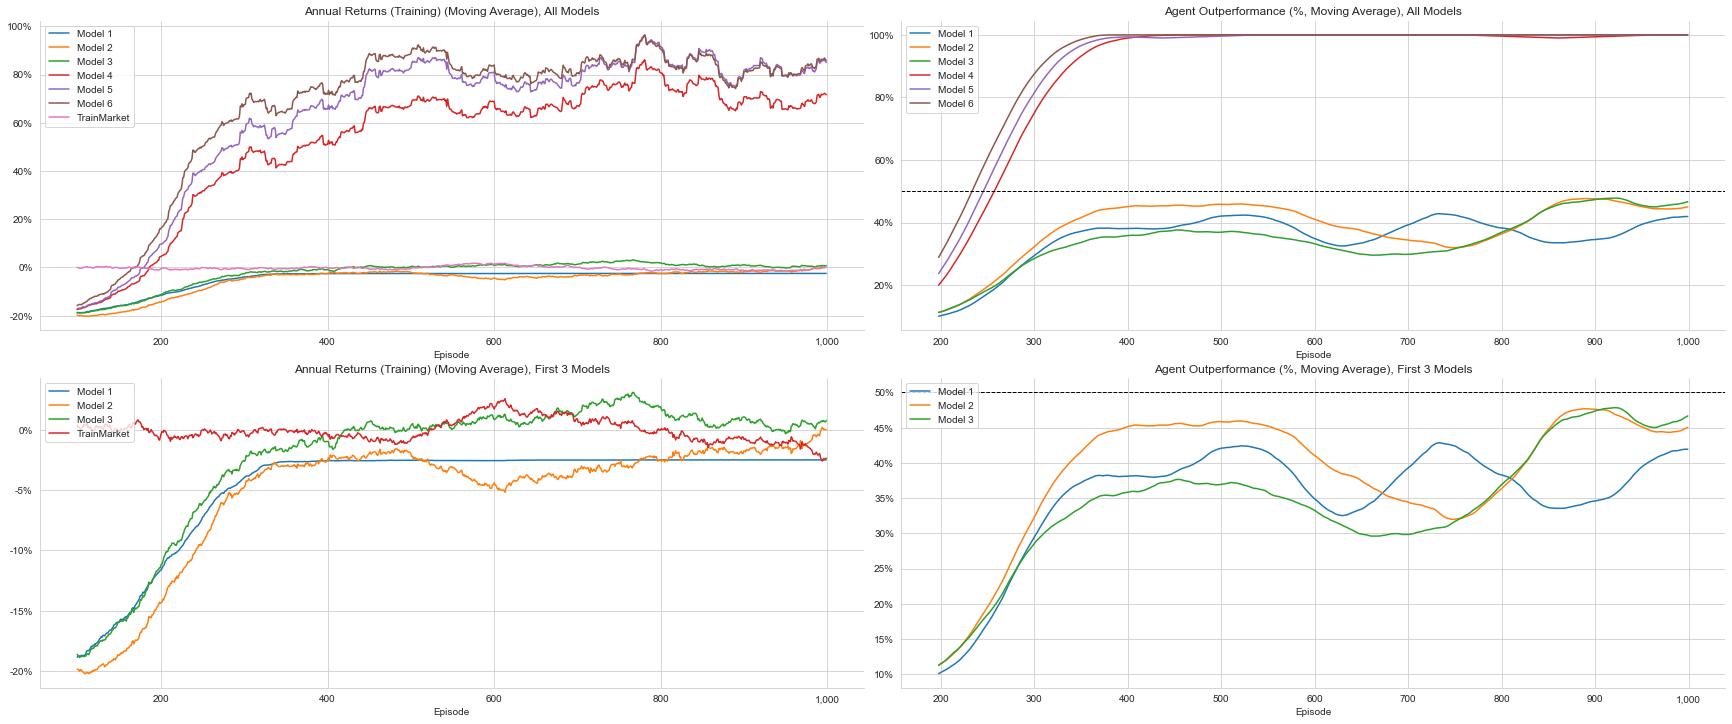

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 10), sharey=False) # Get the screen to plot graphs
# Plot all the training market returns
for r in range(0, len(fx_results_list)):
    curresults = fx_results_list[r]
    data = curresults['TrainAgent']
    #if it's the last one also plot the market data
    if r == len(fx_results_list) - 1:
        data = curresults[['TrainAgent','TrainMarket']]
    # moving average
    df = (data
          .sub(1)
          .rolling(100)
          .mean())
    #plot and add title
    graph = df.plot(ax=axes[0][0],
                    title='Annual Returns (Training) (Moving Average), All Models',
                    legend='')

    #graph.set_ylabel('Portfolio Returns (Last 100 Episodes)')
    graph.set_xlabel('Episode')

# Plot all the win percentage graphs for all the models
for r in range(0, len(fx_results_list)):
    curresults = fx_results_list[r]
    #Rolling average
    df2 = (curresults['Strategy Wins (%)']
           .div(100)
           .rolling(100) # Note: Rolling 100 may not be the common rolling value
           .mean())
    #plot and add title
    graph2 = df2.plot(ax=axes[0][1],
                      title='Agent Outperformance (%, Moving Average), All Models')

    #graph2.set_ylabel('Frequency of Market Outperformance (Last 100 Episodes)')
    graph2.set_xlabel('Episode')

# Plot the first 3 models training market returns, as the last 3 make the scale large and imposible to see the first 3
for r in range(0, 3):
    curresults = fx_results_list[r]
    data = curresults['TrainAgent']

    #if it's the last one also plot the market data
    if r == 2:
        data = curresults[['TrainAgent','TrainMarket']]
    #rolling average
    df = (data
          .sub(1)
          .rolling(100)
          .mean())
    #plot and add title
    graph = df.plot(ax=axes[1][0],
                    title='Annual Returns (Training) (Moving Average), First 3 Models',
                    legend='')

    #graph.set_ylabel('Portfolio Returns (Last 100 Episodes)')
    graph.set_xlabel('Episode')

#plot the first 3 model's win percentage
for r in range(0, 3):
    curresults = fx_results_list[r]
    #rolling average
    df2 = (curresults['Strategy Wins (%)']
           .div(100)
           .rolling(100) # Note: Rolling 100 may not be the common rolling value
           .mean())
    # Plot and add title
    graph2 = df2.plot(ax=axes[1][1],
                      title='Agent Outperformance (%, Moving Average), First 3 Models')

    #graph2.set_ylabel('Frequency of Market Outperformance (Last 100 Episodes)')
    graph2.set_xlabel('Episode')

# make y axis percentages
for axe in axes:
  for ax in axe:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# add 50% line
axes[0][1].axhline(.5, ls='--', c='k', lw=1)
axes[1][1].axhline(.5, ls='--', c='k', lw=1)

# add legends
axes[0][1].legend(fx_labels, loc="upper left")
axes[1][1].legend(fx_labels[:3], loc="upper left")
axes[0][0].legend(fx_labels  + ['TrainMarket'], loc="upper left")
axes[1][0].legend(fx_labels[:3]  + ['TrainMarket'], loc="upper left")
sns.despine()
fig.tight_layout(pad=.5)#make sure the graphs have space

#fig.savefig(results_path / 'performance', dpi=300)

### Plot Test Results

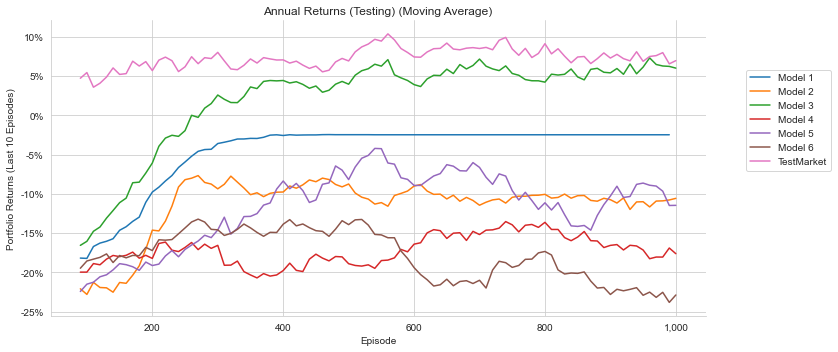

In [13]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 5), sharey=True)
# Plot all the testing results
for r in range(0, len(fx_test_results_list)):
    curresults = fx_test_results_list[r]
    data = curresults['TestAgent']
    #if its the last model plot the test market
    if r == len(fx_test_results_list) - 1:
        data = curresults[['TestAgent','TestMarket']]
    #moving average
    df = (data
          .sub(1)
          .rolling(10)
          .mean())
    # plot and add title
    graph = df.plot(ax=axes,
                title='Annual Returns (Testing) (Moving Average)',
                legend='')
# add legend
fig.legend(labels=fx_labels + ['TestMarket'], bbox_to_anchor=(1.1, 0.5), loc='lower center')

#format the axis
graph.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
graph.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x*10)))

graph.set_xlabel('Episode')
graph.set_ylabel('Portfolio Returns (Last 10 Episodes)')

sns.despine()
fig.tight_layout()

## Add the new data just tested

### print the train returns and the outperformance graph

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), sharey=False) # Get the screen to plot graphs
if model > 3:
  # Plot all the training market returns
  for r in range(0, len(fx_results_list)):
      curresults = fx_results_list[r]
      data = curresults['TrainAgent']
      #if it's the last one also plot the market data
      if r == len(fx_results_list) - 1:
          data = curresults[['TrainAgent','TrainMarket']]
      # moving average
      df = (data
            .sub(1)
            .rolling(100)
            .mean())
      #plot and add title
      graph = df.plot(ax=axes[0],
                      title='Annual Returns (Training) (Moving Average), All Models',
                      alpha=.5)#reduce the opacity

      #graph.set_ylabel('Portfolio Returns (Last 100 Episodes)')
      graph.set_xlabel('Episode')

  # Plot all the win percentage graphs for all the models
  for r in range(0, len(fx_results_list)):
      curresults = fx_results_list[r]
      #Rolling average
      df2 = (curresults['Strategy Wins (%)']
            .div(100)
            .rolling(100) # Note: Rolling 100 may not be the common rolling value
            .mean())
      #plot and add title
      graph2 = df2.plot(ax=axes[1],
                        title='Agent Outperformance (%, Moving Average), All Models',
                      alpha=.5)#reduce the opacity

      #graph2.set_ylabel('Frequency of Market Outperformance (Last 100 Episodes)')
      graph2.set_xlabel('Episode')
else:
  # Plot the first 3 models training market returns, as the last 3 make the scale large and imposible to see the first 3
  for r in range(0, 3):
      curresults = fx_results_list[r]
      data = curresults['TrainAgent']

      #if it's the last one also plot the market data
      if r == 2:
          data = curresults[['TrainAgent','TrainMarket']]
      #rolling average
      df = (data
            .sub(1)
            .rolling(100)
            .mean())
      #plot and add title
      graph = df.plot(ax=axes[0],
                      title='Annual Returns (Training) (Moving Average), First 3 Models',
                      alpha=.5)#reduce the opacity

      #graph.set_ylabel('Portfolio Returns (Last 100 Episodes)')
      graph.set_xlabel('Episode')

  #plot the first 3 model's win percentage
  for r in range(0, 3):
      curresults = fx_results_list[r]
      #rolling average
      df2 = (curresults['Strategy Wins (%)']
            .div(100)
            .rolling(100) # Note: Rolling 100 may not be the common rolling value
            .mean())
      # Plot and add title
      graph2 = df2.plot(ax=axes[1],
                        title='Agent Outperformance (%, Moving Average), First 3 Models',
                      alpha=.5)#reduce the opacity

      #graph2.set_ylabel('Frequency of Market Outperformance (Last 100 Episodes)')
      graph2.set_xlabel('Episode')

# add the new data to the return graph
data = results
# moving average
df = (data
      .sub(1)
      .rolling(100)
      .mean())
#plot and add title
graph = df.plot(ax=axes[0],
                color="black",
                linewidth=3)


#add the new data to the win percent graph
#rolling average
df2 = (curresults['Strategy Wins (%)']
      .div(100)
      .rolling(100) # Note: Rolling 100 may not be the common rolling value
      .mean())
# Plot and add title
graph2 = df2.plot(ax=axes[1],
                color="black",
                linewidth=3)


# make y axis percentages
for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# add 50% line
axes[1].axhline(.5, ls='--', c='k', lw=1)

# add corect legends
if model > 3:
  axes[1].legend(fx_labels + ['Your Model'], loc="upper left")
  axes[0].legend(fx_labels  + ['TrainMarket', 'Your Model'], loc="upper left")
else:
  axes[1].legend(fx_labels[:3] + ['Your Model'], loc="upper left")
  axes[0].legend(fx_labels[:3]  + ['TrainMarket', 'Your Model'], loc="upper left")
sns.despine()
fig.tight_layout(pad=.5)#make sure the graphs have space

#fig.savefig(results_path / 'performance', dpi=300)

### add the test data graph


In [ ]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 5), sharey=True)
# Plot all the testing results
for r in range(0, len(fx_test_results_list)):
    curresults = fx_test_results_list[r]
    data = curresults['TestAgent']
    #if its the last model plot the test market
    if r == len(fx_test_results_list) - 1:
        data = curresults[['TestAgent','TestMarket']]
    #moving average
    df = (data
          .sub(1)
          .rolling(10)
          .mean())
    # plot and add title
    graph = df.plot(ax=axes,
                title='Annual Returns (Testing) (Moving Average)',
                legend='',
                alpha=0.5)#adjust the opacity
#get our data
data = test_results['TestAgent']
#moving average
df = (data
          .sub(1)
          .rolling(10)
          .mean())
# plot and add title
graph = df.plot(color="Black",
                ax=axes,
                linewidth=4)


# add legend
fig.legend(labels=fx_labels + ['TestMarket', 'Your Market'], bbox_to_anchor=(1.1, 0.5), loc='lower center')

#format the axis
graph.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
graph.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x*10)))

graph.set_xlabel('Episode')
graph.set_ylabel('Portfolio Returns (Last 10 Episodes)')

sns.despine()
fig.tight_layout()

### plot just the newly trained model's data

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5), sharey=False)
#plot the train data
#get the data
targets = ['TrainAgent', 'TrainMarket']
data = results[targets]
#moving average
df = (data
      .sub(1)
      .rolling(100)
      .mean())

graph = df.plot(ax=axes[0],title='Training Annual Returns (Moving Average) for Your Model')
#format the axis
graph.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
graph.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#plot the test data
#get the data
targets = ['TestAgent', 'TestMarket']
data = test_results[targets]
#moving average
df = (data
      .sub(1)
      .rolling(10)
      .mean())

graph = df.plot(ax=axes[1],title='Testing Annual Returns (Moving Average) for Your Model')

#format the axis
graph.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x*10)))
graph.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

graph.set_xlabel('Episode')
graph.set_ylabel('Annual Return %')

sns.despine()
fig.tight_layout()

